In [2]:
import os
import sys
import random
import warnings

import numpy as np
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt

from tqdm import tqdm

from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
import skimage

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
import cv2
# Set some parameters

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# Set some parameters
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3

TRAIN_PATH = './train_img/'
TEST_PATH = './test_img/'
TRAIN_MASK_PATH = './train_mask/'
TEST_MASK_PATH = './test_mask/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

print("Imported all the dependencies")

Imported all the dependencies


In [5]:
# Get train and test IDs
train_ids = []
train_mask_ids = []
for filename in os.listdir(TRAIN_PATH):
    train_ids.append(filename)
    
for filename in os.listdir(TRAIN_MASK_PATH):
    train_mask_ids.append(filename)

test_ids = []
test_mask_ids = []
for filename in os.listdir(TEST_PATH):
    test_ids.append(filename)
for filename in os.listdir(TEST_MASK_PATH):
    test_mask_ids.append(filename)
    
train_ids.sort()
train_mask_ids.sort()
test_ids.sort()
test_mask_ids.sort()


In [6]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_mask_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print("X_train",X_train.shape)
print("Y_train",Y_train.shape)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
	path = TRAIN_PATH + id_
	img = imread(path)[:,:,:IMG_CHANNELS] 
	img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
	X_train[n] = img
	mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
for n, id_ in tqdm(enumerate(train_mask_ids), total=len(train_mask_ids)):
	path = TRAIN_MASK_PATH + id_
	mask = imread(path)
	mask = skimage.color.rgb2gray(mask)
	mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True), axis=-1)
	Y_train[n] = mask

print('Done!')

X_train (54, 512, 512, 3)
Y_train (54, 512, 512, 1)
Getting and resizing train images and masks ... 
100%|██████████| 54/54 [00:03<00:00, 14.35it/s]Done!



In [7]:
# from PIL import Image

# for filename in os.listdir(TRAIN_MASK_PATH):
#     purename = filename.split(".")[0]
#     pat = os.path.join(TRAIN_MASK_PATH, filename)
#     im = Image.open(pat)
#     im = im.convert('L')
#     im.save(os.path.join(TRAIN_MASK_PATH, f"{purename}.png"), "PNG") 

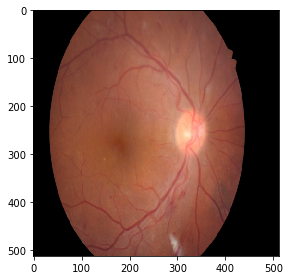

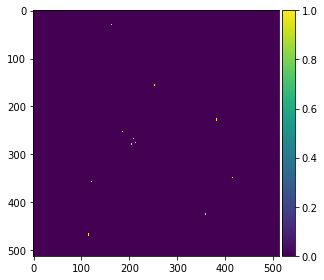

In [8]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids) - 1)

imshow(X_train[ix])
plt.show();
#plt.savefig('img.png')

imshow(Y_train[ix])
plt.show();
#plt.savefig('mask.png')

In [9]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
print("The model is defined")

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 512, 512, 16) 0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [10]:
# Fit model
earlystopper = EarlyStopping(monitor='val_loss', verbose=1)
checkpointer = ModelCheckpoint('./model.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=1, epochs=10, callbacks=[checkpointer])

Train on 43 samples, validate on 11 samples
Epoch 1/10
43/43 [==============================] - 16s 382ms/step - loss: 0.0609 - accuracy: 0.9808 - val_loss: 0.0090 - val_accuracy: 0.9990

Epoch 00001: val_loss improved from inf to 0.00898, saving model to ./model.h5
Epoch 2/10
43/43 [==============================] - 10s 242ms/step - loss: 0.0091 - accuracy: 0.9989 - val_loss: 0.0079 - val_accuracy: 0.9990

Epoch 00002: val_loss improved from 0.00898 to 0.00785, saving model to ./model.h5
Epoch 3/10
43/43 [==============================] - 10s 243ms/step - loss: 0.0087 - accuracy: 0.9989 - val_loss: 0.0078 - val_accuracy: 0.9990

Epoch 00003: val_loss improved from 0.00785 to 0.00782, saving model to ./model.h5
Epoch 4/10
43/43 [==============================] - 11s 258ms/step - loss: 0.0086 - accuracy: 0.9989 - val_loss: 0.0084 - val_accuracy: 0.9990

Epoch 00004: val_loss did not improve from 0.00782
Epoch 5/10
43/43 [==============================] - 11s 252ms/step - loss: 0.0086 - 

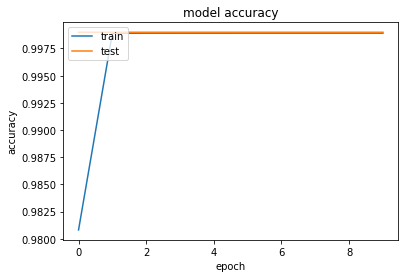

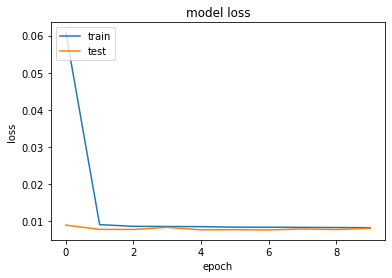

In [11]:
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
# Get and resize test images
X_test = np.zeros((1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((1, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print("X_test",X_test.shape)
print("Y_test",Y_test.shape)

path = os.path.join(TEST_PATH, "IDRiD_55.jpg")
img = imread(path)[:,:,:IMG_CHANNELS] 
ori_height = img.shape[0]
ori_width = img.shape[1]
img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
X_test[0] = img

mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
path = os.path.join(TEST_MASK_PATH, "IDRiD_55_MA.tif")
mask = imread(path)
mask = skimage.color.rgb2gray(mask)
mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True), axis=-1)
Y_test[0] = mask

print('Done!')

X_test (1, 512, 512, 3)
Y_test (1, 512, 512, 1)
Done!


In [13]:
#Predict on train, val and test
model = load_model('./model_2500.h5')

preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)

1/1 [==============================] - 0s 235ms/step


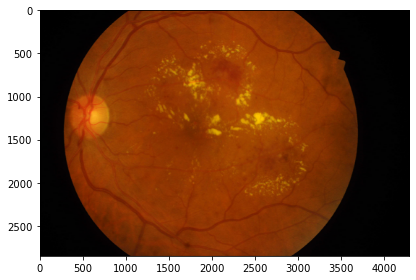

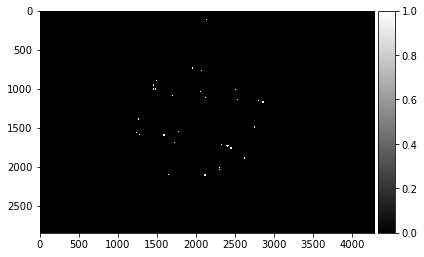

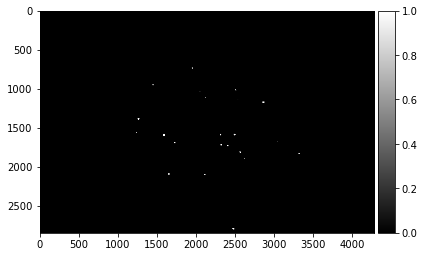

In [14]:
# Perform a sanity check on some random training samples
img = resize(X_test[0], (ori_height, ori_width))
imshow(img)
plt.show();

ground_img = resize(np.squeeze(Y_test[0]), (ori_height, ori_width), mode='constant', preserve_range=True)
imshow(ground_img,cmap='gray')
plt.show();

pred_img = resize(np.squeeze(preds_test_t[0]), (ori_height, ori_width), mode='constant', preserve_range=True)
imshow(pred_img,cmap='gray')
plt.show();